In [1]:
from __future__ import annotations
from typing import List
from itertools import product
from s7.models import create_config
from s7.xlsparser import XLSParser
from s7.classgen import class_factory
import numpy as np

# Import Configuration
xls_config = create_config('/home/jovyan/work/semantic_interop_story_2/inhibitor_conf.yml')

# Generate Specific Parser from config
specific_parser = XLSParser(xls_config)

# Generate entity instance (not a S7-model yet...)
XLSData = class_factory("XLSData", specific_parser)

x = XLSData()

print (x.inhibitorEfficiency)

help(x)

[82.84807910472972, 82.70578220798093, -32.10177835991128, 0.7790838781530862, 31.69712512083033]
Help on XLSData in module s7.classgen object:

class XLSData(BaseExt)
 |  Method resolution order:
 |      XLSData
 |      BaseExt
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__ lambda self
 |  
 |  set_property lambda self, key, value
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  casNumber
 |  
 |  impedance_kohm_24h
 |  
 |  impedance_log_24h
 |  
 |  impedance_ohm_24h
 |  
 |  inhibitorEfficiency
 |  
 |  runID
 |  
 |  sampleType
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors inherited from BaseExt:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



1. registrerer excel ark i OTEAPI (datasource)
2. definere mappings

3. ifra python, enkapsuler specific parser  i et python objekt
4. generere lokale mappings ifra (2)


In [2]:
import math
def half(x):
    return x/2

def double(x):
    return x*2

list(map(half, x.inhibitorEfficiency))


impedanceLogOhm = 4.30561377998236
impedanceOhm = math.pow(10, impedanceLogOhm)
impedancekOhmCm2 = impedanceOhm*0.785/1000.0
inhibitorEfficiencyEIS24h = (1-13.562/impedancekOhmCm2)*100


print (impedanceOhm)

def inhibitorEfficiencyEIS24h(impedance_kOhm_cm2):
    return (1.0-13.562/impedance_kOhm_cm2)*100.0

20212.208984374793


In [3]:
v = 3
def foo(arg):
    print (arg)

d = {}
d.update({'arg': v})
foo(**d)

3


[41.42403955236486, 41.352891103990466, -16.05088917995564, 0.3895419390765431, 15.848562560415164]


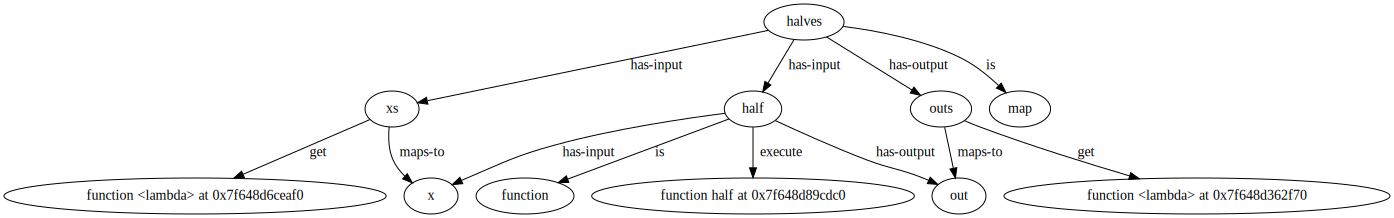

In [4]:
from s7.graph import Graph

def half(x):
    return x/2

def double(x):
    return x*2

def map_fn(fn, xs):
    return list(fn(_) for _ in xs)


g = Graph()
g.clear()
g.append(('xs', 'get', lambda : x.inhibitorEfficiency))
g.append(('half', 'has-input', 'x'))
g.append(('half', 'has-output', 'out'))
g.append(('half', 'is', 'function'))
g.append(('half', 'execute', half))
g.append(('xs', 'maps-to', 'x'))

g.append(('halves', 'is', 'map'))
g.append(('halves', 'has-input', 'xs'))
g.append(('halves', 'has-input', 'half'))
g.append(('halves', 'has-output', 'outs'))
g.append(('outs', 'get', lambda xs: map_fn(half, xs)))
g.append(('outs', 'maps-to', 'out'))

v = {}
for _, _, inp in g.match('halves', 'has-input'):    
    for _, _, val in g.match(inp, 'get'):
        v.update({inp: val()})
            
for _, _, fn in g.match('outs', 'get'):
    print(fn(**v))
    
g.plot()


[41.42403955236486, 41.352891103990466, -16.05088917995564, 0.3895419390765431, 15.848562560415164]


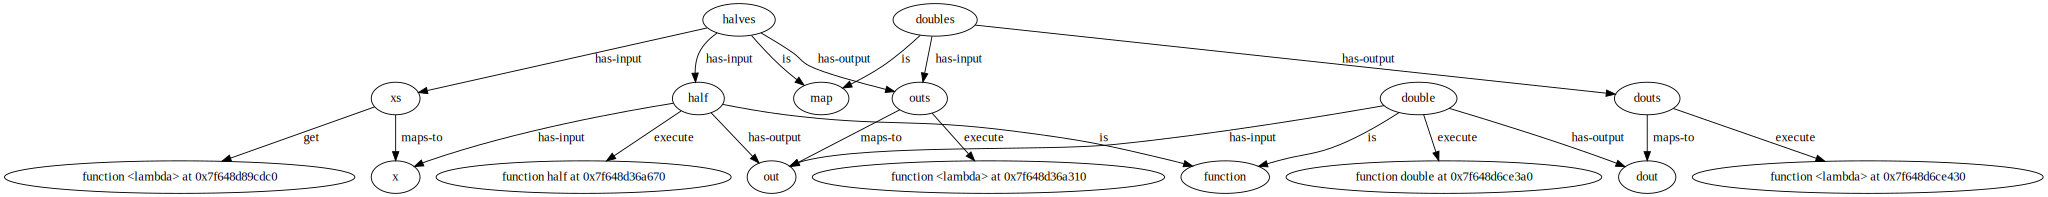

In [5]:
from s7.graph import Graph

def half(x):
    return x/2


def map_fn(fn, xs):
    return list(fn(_) for _ in xs)


g = Graph()
g.clear()
g.append(('xs', 'get', lambda : x.inhibitorEfficiency))
g.append(('half', 'has-input', 'x'))
g.append(('half', 'has-output', 'out'))
g.append(('half', 'is', 'function'))
g.append(('half', 'execute', half))
g.append(('xs', 'maps-to', 'x'))

g.append(('double', 'has-input', 'out'))
g.append(('double', 'has-output', 'dout'))
g.append(('double', 'is', 'function'))
g.append(('double', 'execute', double))
g.append(('doubles', 'is', 'map'))
g.append(('doubles', 'has-input', 'outs'))
g.append(('doubles', 'has-output', 'douts'))

g.append(('douts', 'execute', lambda xs: map_fn(double, xs)))
g.append(('douts', 'maps-to', 'dout'))

g.append(('halves', 'is', 'map'))
g.append(('halves', 'has-input', 'xs'))
g.append(('halves', 'has-input', 'half'))
g.append(('halves', 'has-output', 'outs'))
g.append(('outs', 'execute', lambda xs: map_fn(half, xs)))
g.append(('outs', 'maps-to', 'out'))

v = {}
for _, _, inp in g.match('halves', 'has-input'):    
    for _, _, val in g.match(inp, 'get'):
        v.update({inp: val()})
            
for _, _, fn in g.match('outs', 'execute'):
    print(fn(**v))
    
g.plot()


In [6]:
g.path('dout', 'xs')


reverse double
forward out
reverse half
forward x
reverse xs


['dout', 'double', 'out', 'half', 'x', 'xs']

In [7]:
# fetch function for sources
def get_data_function(graph, concept):
    for _, _, fn in graph.match(concept, 'get'):
        return fn

    
# fetch executable function 
def get_function(graph, concept):
    for _, _, fn in graph.match(concept, 'execute'):
        return fn
    
def composite_function(f, g):      
    return lambda x : f(g(x))


# get mapped half function (halves)
hs = get_function(g, 'outs')


# get mapped double function (doubles)
ds = get_function(g, 'douts')


# Get function from fetching data from xs 
v = get_data_function(g, 'xs')


thepipe = composite_function(ds, hs)

thepipe(v())
  


[82.84807910472972,
 82.70578220798093,
 -32.10177835991128,
 0.7790838781530862,
 31.69712512083033]

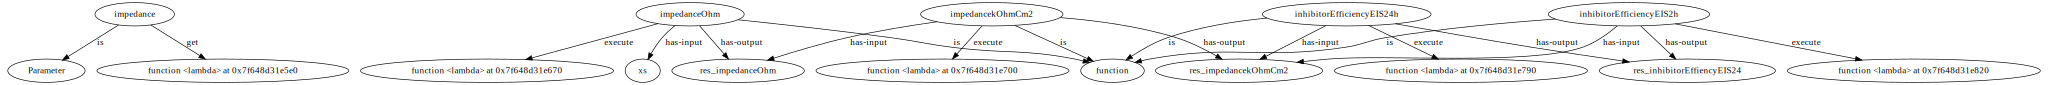

In [8]:
g = Graph()
g.clear()


impedanceLogOhm = 4.30561377998236

def map_fn(fn, xs):
    return list(fn(_) for _ in xs)

def impedanceOhm(impedanceLogOhm):
    return math.pow(10, impedanceLogOhm)

def impedancekOhmCm2(impedanceOhm):
    return impedanceOhm*0.785/1000.0

def inhibitorEfficiencyEIS24h(impedancekOhmCm2):
    return (1.0-13.562/impedancekOhmCm2)*100.0
    
def inhibitorEfficiencyEIS2h(impedanceLogOhm2h):
    ohm = math.pow(10, impedanceLogOhm2h)
    impflux  = ohm*0.785/1000.0
    eff = (1-14.025/impflux)*100
    return eff
    
    
def composite_function(f, g):      
    return lambda x : f(g(x))


efficiency = composite_function(inhibitorEfficiencyEIS24h, composite_function(impedancekOhmCm2, impedanceOhm))
efficiency(impedanceLogOhm)

g.append(('impedance', 'is', 'Parameter'))
g.append(('impedance', 'get', lambda : x.impedance_log_24h))
g.append(('impedanceOhm', 'is', 'function'))
g.append(('impedanceOhm', 'execute', lambda xs: map_fn(impedanceOhm, xs)))
g.append(('impedanceOhm', 'has-input', 'xs'))
g.append(('impedanceOhm', 'has-output', 'res_impedanceOhm'))


g.append(('impedancekOhmCm2', 'is', 'function'))
g.append(('impedancekOhmCm2', 'execute', lambda xs: map_fn(impedancekOhmCm2, xs)))
g.append(('impedancekOhmCm2', 'has-input', 'res_impedanceOhm'))
g.append(('impedancekOhmCm2', 'has-output', 'res_impedancekOhmCm2'))

g.append(('inhibitorEfficiencyEIS24h', 'is', 'function'))
g.append(('inhibitorEfficiencyEIS24h', 'execute', lambda xs: map_fn(inhibitorEfficiencyEIS24h, xs)))
g.append(('inhibitorEfficiencyEIS24h', 'has-input', 'res_impedancekOhmCm2'))
g.append(('inhibitorEfficiencyEIS24h', 'has-output', 'res_inhibitorEffiencyEIS24'))

g.append(('inhibitorEfficiencyEIS2h', 'is', 'function'))
g.append(('inhibitorEfficiencyEIS2h', 'execute', lambda xs: map_fn(inhibitorEfficiencyEIS2h, xs)))
g.append(('inhibitorEfficiencyEIS2h', 'has-input', 'res_impedancekOhmCm2'))
g.append(('inhibitorEfficiencyEIS2h', 'has-output', 'res_inhibitorEffiencyEIS24'))
# lambda xs: map_fn(double, xs))
g.plot()


In [9]:
g.path('res_inhibitorEffiencyEIS24', 'xs')

reverse inhibitorEfficiencyEIS24h
forward function
reverse impedanceOhm
forward <function <lambda> at 0x7f648d31e670>


['res_inhibitorEffiencyEIS24',
 'inhibitorEfficiencyEIS24h',
 'function',
 'impedanceOhm',
 <function __main__.<lambda>(xs)>]

In [10]:
g.gen_cytoscape()

{ data: { id: 'Parameter' } },
{ data: { id: 'impedanceOhm' } },
{ data: { id: '<function <lambda> at 0x7f648d31e820>' } },
{ data: { id: 'xs' } },
{ data: { id: '<function <lambda> at 0x7f648d31e5e0>' } },
{ data: { id: 'impedancekOhmCm2' } },
{ data: { id: 'res_impedanceOhm' } },
{ data: { id: 'res_inhibitorEffiencyEIS24' } },
{ data: { id: '<function <lambda> at 0x7f648d31e700>' } },
{ data: { id: '<function <lambda> at 0x7f648d31e790>' } },
{ data: { id: 'impedance' } },
{ data: { id: '<function <lambda> at 0x7f648d31e670>' } },
{ data: { id: 'res_impedancekOhmCm2' } },
{ data: { id: 'inhibitorEfficiencyEIS24h' } },
{ data: { id: 'inhibitorEfficiencyEIS2h' } },
{ data: { id: 'function' } },
{ data: { id: 'is_impedance_Parameter', source: 'impedance', target: 'Parameter', label: 'is' } },
{ data: { id: 'get_impedance_<function <lambda> at 0x7f648d31e5e0>', source: 'impedance', target: '<function <lambda> at 0x7f648d31e5e0>', label: 'get' } },
{ data: { id: 'is_impedanceOhm_function'

In [11]:
from functools import reduce
def composite_function(*func):
     
    def compose(f, g):
        return lambda x : f(g(x))
              
    return reduce(compose, func, lambda x : x)


In [12]:
my_path = ['impedanceOhm', 'impedancekOhmCm2', 'inhibitorEfficiencyEIS24h']

my_fn = []
for p in my_path:
    my_fn.append(get_function(g, p))


efficiency = composite_function(*my_fn)

data = get_data_function(g, 'impedance')

efficiency(data())


[0.7340240473116283,
 0.7337659754132128,
 0.6605123859502069,
 0.6721426615868396,
 0.6866055021639835]

In [13]:
efficiency = composite_function(*path)
efficiency(data())

NameError: name 'path' is not defined

In [ ]:

from s7.graph import Graph
g = Graph()
d = XLSData()

print (d.sampleType)

g.append(('entity', 'hasProperty', 'entity:sampleType'))
g.append(('entity:sampleType', 'propertyOf', 'entity'))

g.append(('entity', 'hasProperty', 'entity:casNumber'))
g.append(('entity:casNumber', 'propertyOf', 'entity'))

g.append(('entity:sampleType', 'mapsTo', 'ontology:sampleType'))
g.append(('entity:sampleType', 'propertyOf', 'entity'))

g.append(('ontology:sampleType', 'mapsfrom', 'entity:sampleType'))
g.append(('entity:casNumber', 'mapsTo', 'ontology:casNumber'))
g.append(('ontology:casNumber', 'mapsFrom', 'entity:casNumber'))
g.append(('entity:inhibitorEfficiency', 'mapsTo', 'ontology:inhibitorEfficiency'))
g.append(('ontology:inhibitorEfficiency', 'mapsTo', 'entity:inhibitorEfficiency'))

g.append(((lambda : d.sampleType), 'executes', 'entity:sampleType'))
g.append(((lambda : d.casNumber), 'executes', 'entity:casNumber'))
g.append(((lambda : d.inhibitorEfficiency), 'executes', 'entity:inhibitorEfficiency'))

# consumer mapping
g.append(('consumer:eff', 'mapsTo', 'ontology:inhibitorEfficiency'))
g.append(('consumer:cas', 'mapsTo', 'ontology:casNumber'))


In [ ]:
a = True
a &= True
a &= False
a &= True
a

In [ ]:
l = [1,2,2,2,34,4,3,2]
for s in set(l):
    print (s)

In [ ]:
gr = Graph()
gr.append(('a', 'to', 'b'))
gr.append(('a', 'to', 'c'))
gr.append(('a', 'to', 'd'))
gr.plot()
gr.gen_cytoscape()

In [27]:

f = Graph()
f.clear()
f.append(('subclass1', 'is-a', 'Class'))
f.append(('subclass2', 'is-a', 'Class'))
f.append(('subclass3', 'is-a', 'Class'))
f.append(('subclass4', 'is-a', 'Class'))
f.append(('subclass4_1', 'is-a', 'subclass4'))
f.append(('subclass4_2', 'is-a', 'subclass4'))
f.append(('subclass4_2', 'relates-to', 'somethingelse'))

for s, _, _ in f.match(None, 'is-a', 'subclass4'):
    print (s)           

subclass4_1
subclass4_2


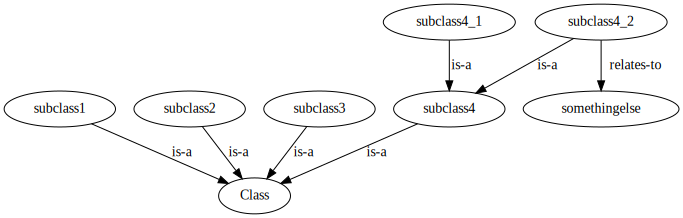

In [30]:
f.plot()